# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [ ]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Data ingestion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/20.11.24/Spotifyy5.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

## Data exploration

In [ ]:
df.head(5)

,artists,acousticness,instrumentalness,valence,mmpopularity,track_genre
0,0,0.0322,0.000001,0.715,0.73,0
1,1,0.9240,0.000006,0.267,0.55,0
2,2,0.2100,0.000000,0.120,0.57,0
3,3,0.9050,0.000071,0.143,0.71,0
4,4,0.4690,0.000000,0.167,0.82,0


In [ ]:
print(df.shape)
print(df.describe())

(8521, 6)
           artists  acousticness  instrumentalness      valence  mmpopularity  \
count  8521.000000   8521.000000       8521.000000  8521.000000   8521.000000   
mean   1204.677268      0.342415          0.211535     0.465025      0.326734   
std     713.667735      0.352566          0.347458     0.274183      0.226214   
min       0.000000      0.000000          0.000000     0.000000      0.000000   
25%     681.000000      0.011600          0.000000     0.224000      0.180000   
50%    1147.000000      0.200000          0.000540     0.447000      0.290000   
75%    1832.000000      0.681000          0.324000     0.691000      0.510000   
max    2513.000000      0.996000          0.993000     0.995000      0.930000   

       track_genre  
count  8521.000000  
mean      3.891093  
std       2.548058  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       6.000000  
max       8.000000  


## Есть ли пропуски?

In [ ]:
df.isnull().values.any()

False

## Class distribution (0 to 8)

In [ ]:
df['track_genre'].value_counts()

,count
track_genre,
7,989
0,985
1,985
2,982
3,980
6,978
5,960
4,905
8,757


<ipython-input-52-cec1d73d3da4>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['track_genre'], sort = True)


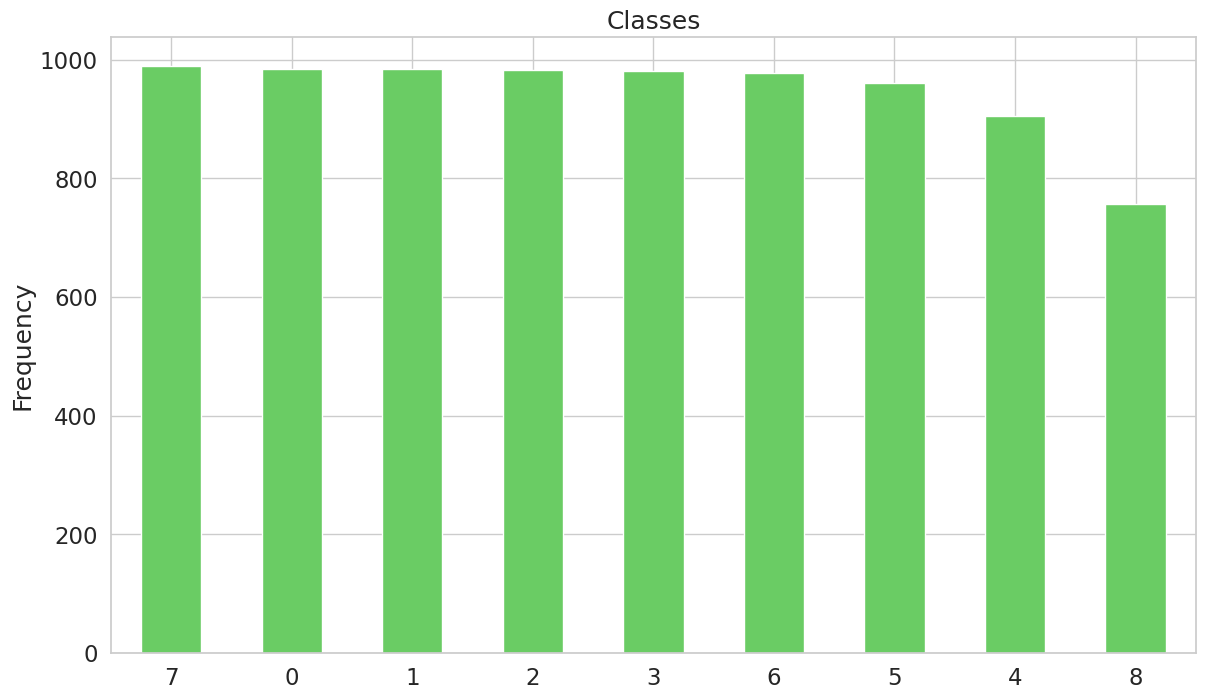

In [ ]:
count_classes = pd.value_counts(df['track_genre'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Classes")
plt.xticks(range(9), df['track_genre'].value_counts().index)
plt.xlabel("")
plt.ylabel("Frequency");

Наш набор данных несбалансирован не в пользу класса 8 . Это требует дальнейшего изучения данных

In [ ]:
midDF = df[df.track_genre == 3]
lastDF = df[df.track_genre == 8]

In [ ]:
midDF.shape

(980, 6)

In [ ]:
lastDF.shape

(757, 6)

Давайте теперь посмотрим на позитивность, задействованную в двух классах.

In [ ]:
midDF.valence.describe()

,valence
count,980.000000
mean,0.498390
std,0.224998
min,0.036400
25%,0.319000
50%,0.488500
75%,0.678500
max,0.968000


In [ ]:
lastDF.valence.describe()

,valence
count,757.000000
mean,0.606846
std,0.242983
min,0.058800
25%,0.405000
50%,0.639000
75%,0.836000
max,0.978000


Graphically speaking ...`

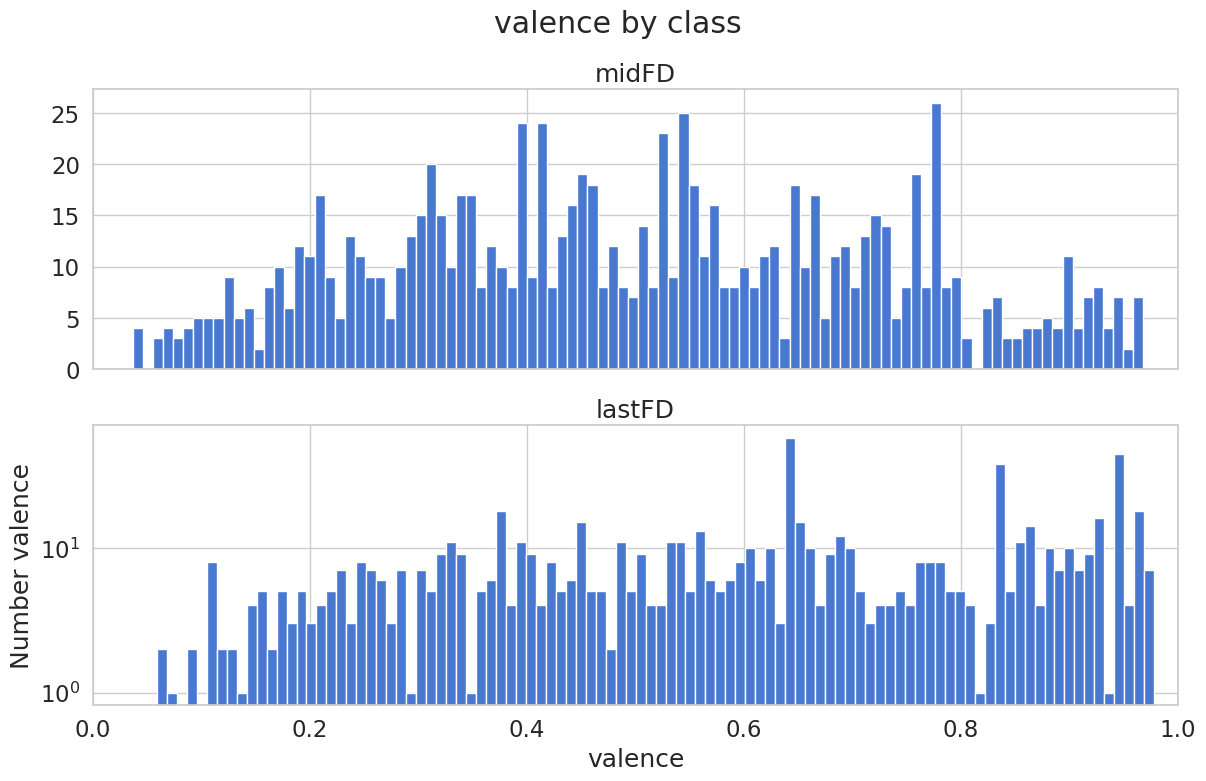

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('valence by class')

bins = 100

ax1.hist(midDF.valence, bins = bins)
ax1.set_title('midFD')

ax2.hist(lastDF.valence, bins = bins)
ax2.set_title('lastFD')

plt.xlabel('valence')
plt.ylabel('Number valence')
plt.xlim((0, 1))
plt.yscale('log')
plt.show();

Влияет instrumentalness на valence?

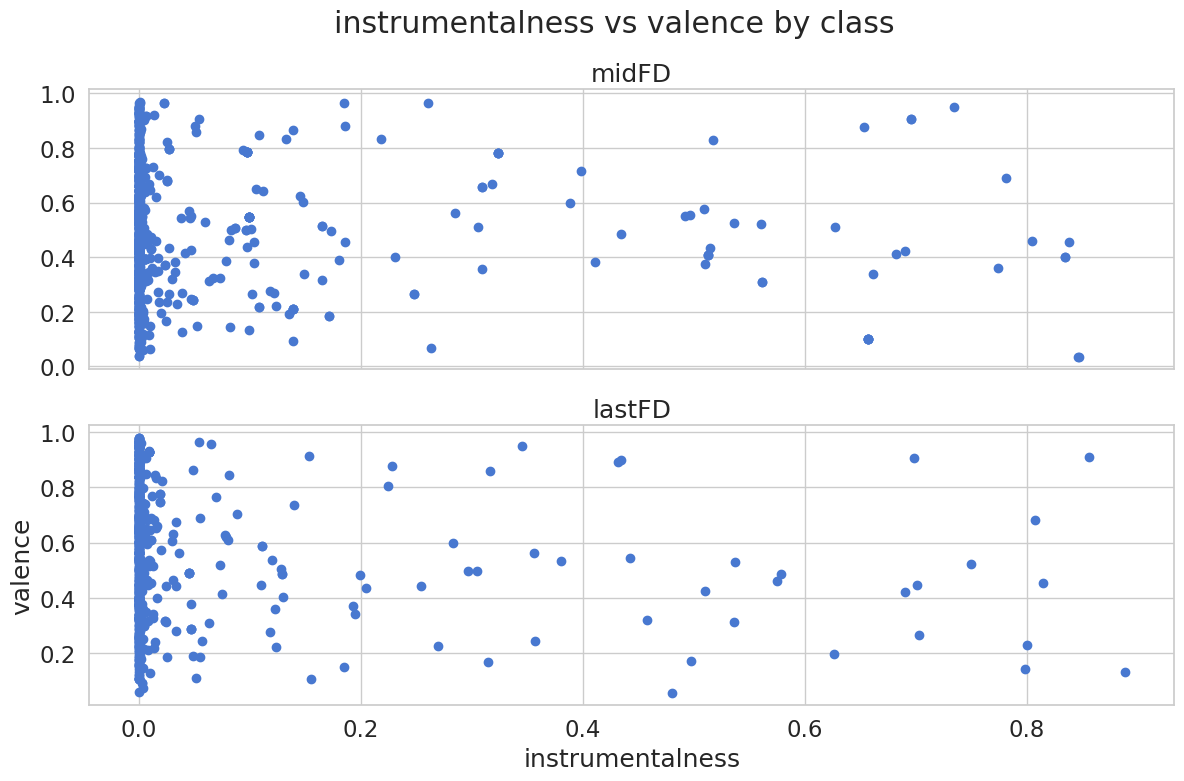

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('instrumentalness vs valence by class')

ax1.scatter(midDF.instrumentalness, midDF.valence)
ax1.set_title('midFD')

ax2.scatter(lastDF.instrumentalness, lastDF.valence)
ax2.set_title('lastFD')

plt.xlabel('instrumentalness')
plt.ylabel('valence')
plt.show()

Таким образом, очевидно, что instumentalness не имеет никакого отношения к valence.

## Preprocessing

Поскольку, как показано выше, instrumentalness не влияет на track_genre, эта функция не будет способствовать обучению модели. Следовательно, мы можем отказаться от него.

In [ ]:
transactionData = df.drop(['instrumentalness'], axis=1)

Также давайте стандартизируем artists.

In [ ]:
transactionData['artists'] = StandardScaler().fit_transform(transactionData['artists'].values.reshape(-1, 1))

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только track_genre = 8, а в тестовом наборе данных будут как жанры трека всех представленных видов.

In [ ]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
# X_train = X_train[X_train.track_genre == 8]
X_train = X_train.drop(['track_genre'], axis=1)
#print(type(X_train))
y_test = X_test['track_genre']
X_test = X_test.drop(['track_genre'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


1705


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 4,3,3,4 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 4 узлов, соответствующих 4 функциям в элементе входных данных.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 3),
            nn.Tanh(),
            nn.Linear(3, 2),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(2, 3),
           nn.Tanh(),
           nn.Linear(3, 4),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [ ]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 20
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шагами мы изменяем градиент.

In [ ]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [ ]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [ ]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './Spotifyyy.pth')

epoch [1/100], loss:0.3177
epoch [2/100], loss:0.2885
epoch [3/100], loss:0.2738
epoch [4/100], loss:0.2673
epoch [5/100], loss:0.2650
epoch [6/100], loss:0.2639
epoch [7/100], loss:0.2631
epoch [8/100], loss:0.2626
epoch [9/100], loss:0.2622
epoch [10/100], loss:0.2618
epoch [11/100], loss:0.2615
epoch [12/100], loss:0.2613
epoch [13/100], loss:0.2612
epoch [14/100], loss:0.2612
epoch [15/100], loss:0.1964
epoch [16/100], loss:0.1509
epoch [17/100], loss:0.1496
epoch [18/100], loss:0.1493
epoch [19/100], loss:0.1491
epoch [20/100], loss:0.1489
epoch [21/100], loss:0.1488
epoch [22/100], loss:0.1486
epoch [23/100], loss:0.1484
epoch [24/100], loss:0.1481
epoch [25/100], loss:0.1479
epoch [26/100], loss:0.1475
epoch [27/100], loss:0.1472
epoch [28/100], loss:0.1467
epoch [29/100], loss:0.1462
epoch [30/100], loss:0.1456
epoch [31/100], loss:0.1449
epoch [32/100], loss:0.1442
epoch [33/100], loss:0.1432
epoch [34/100], loss:0.1422
epoch [35/100], loss:0.1411
epoch [36/100], loss:0.1400
e

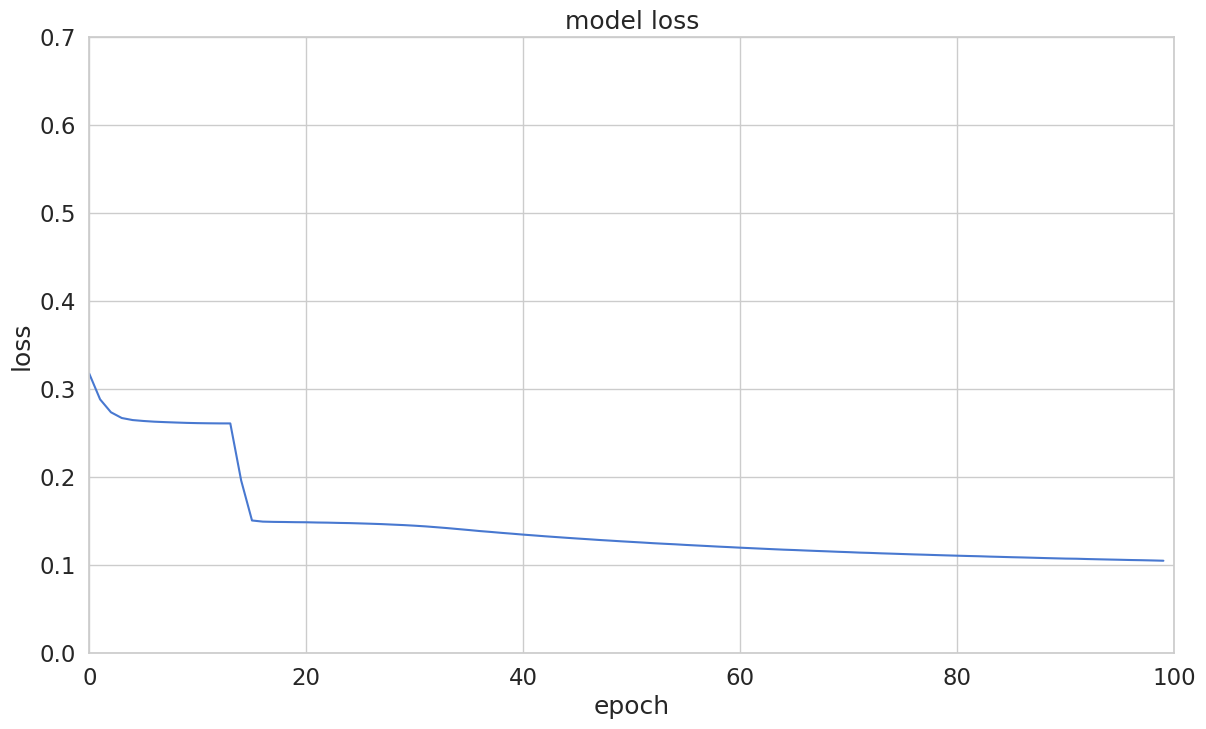

In [ ]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.00,0.70])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['track_genre'] = y_test

In [ ]:
reconstructionErrorDF.describe()

,pred_loss,track_genre
count,1705.000000,1705.000000
mean,0.217878,3.874487
std,0.230162,2.554470
min,0.000466,0.000000
25%,0.049683,2.000000
50%,0.117026,4.000000
75%,0.297571,6.000000
max,0.987499,8.000000


# Reconstruction Errors without 8 class

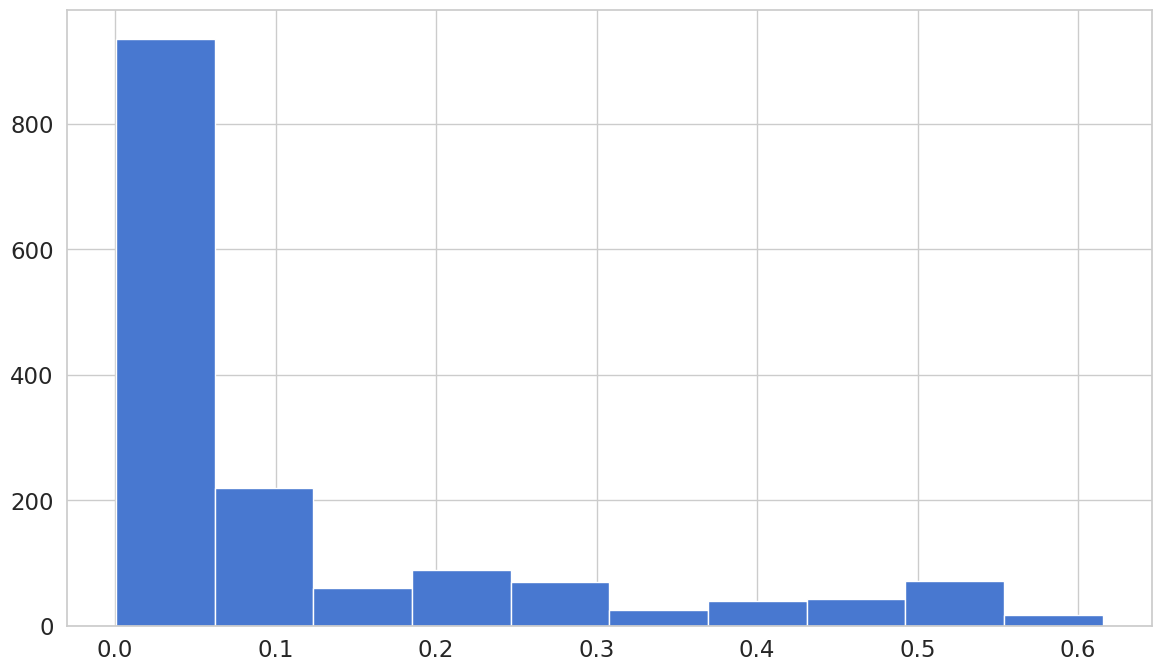

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['track_genre'] != 8) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with class8

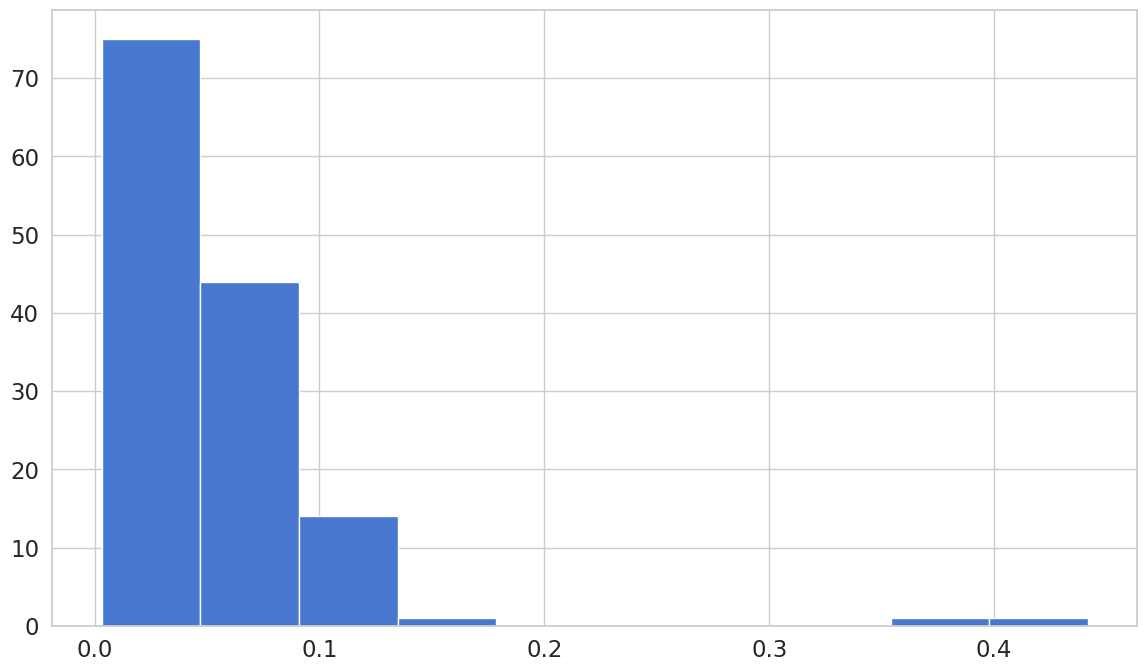

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['track_genre']== 8) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

In [ ]:
'''
Вспомогательная функция для построения confusion matrix для каждого класса
'''
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

In [ ]:
reconstructionErrorDF.track_genre

,track_genre
0,7
1,7
2,2
3,1
4,0
...,...
1700,7
1701,3
1702,5
1703,6


In [ ]:
reconstructionErrorDF.pred_loss

,pred_loss
0,0.029601
1,0.003327
2,0.107748
3,0.324475
4,0.523176
...,...
1700,0.022295
1701,0.049828
1702,0.016819
1703,0.022954


In [ ]:
classes = np.unique(reconstructionErrorDF.track_genre).astype(int)

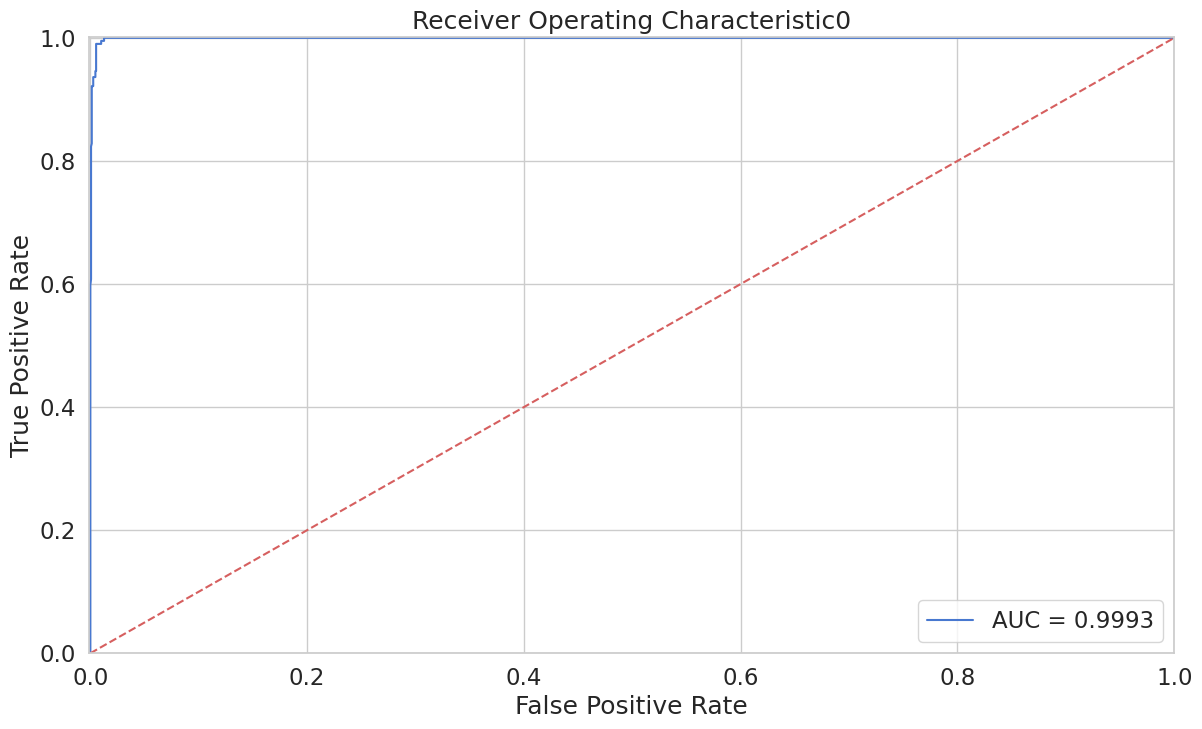

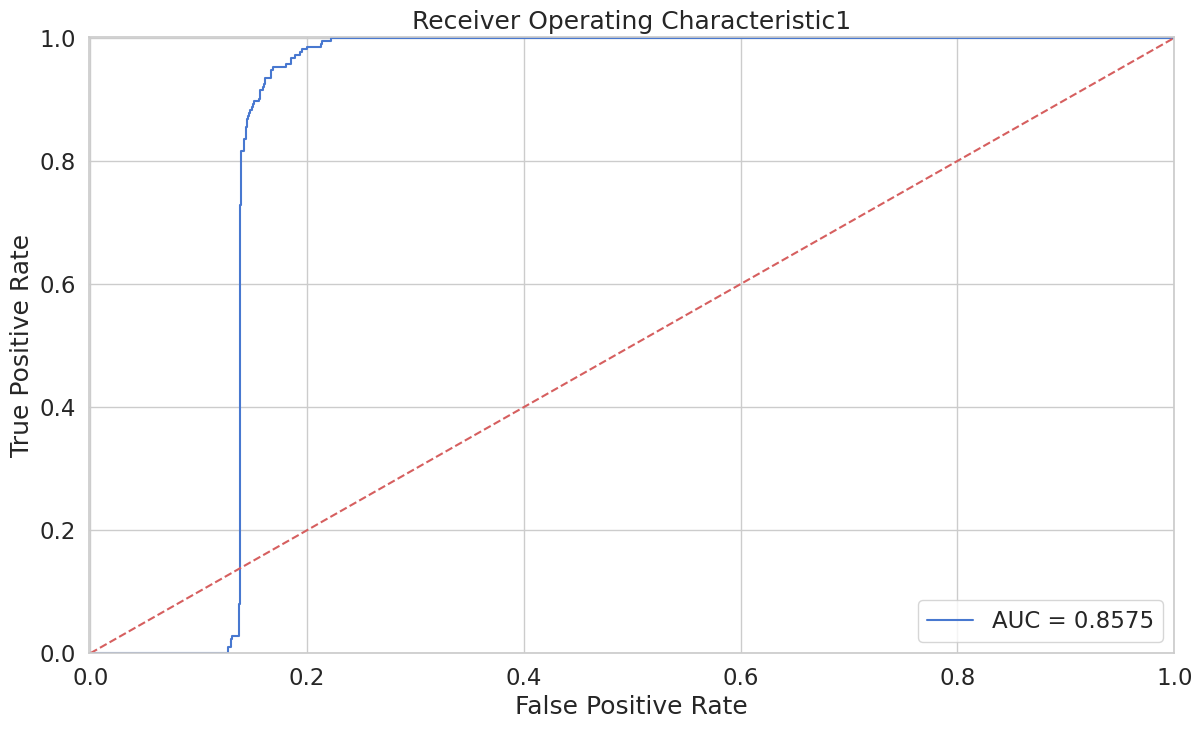

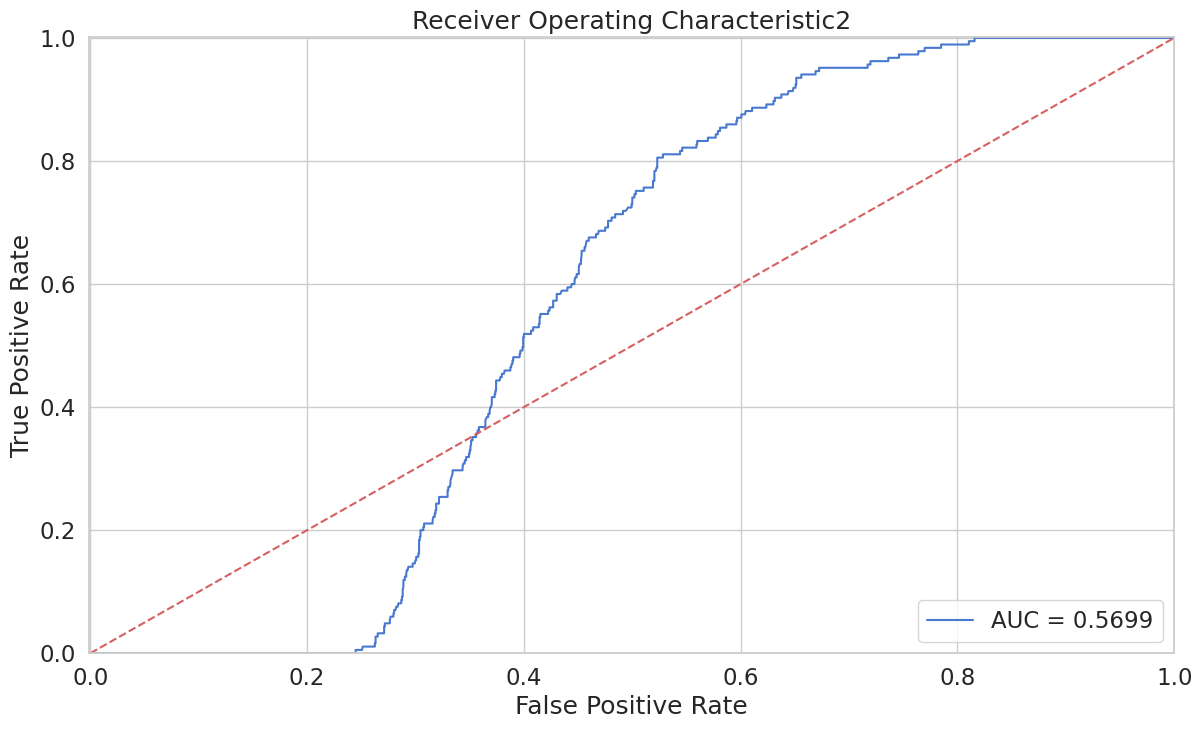

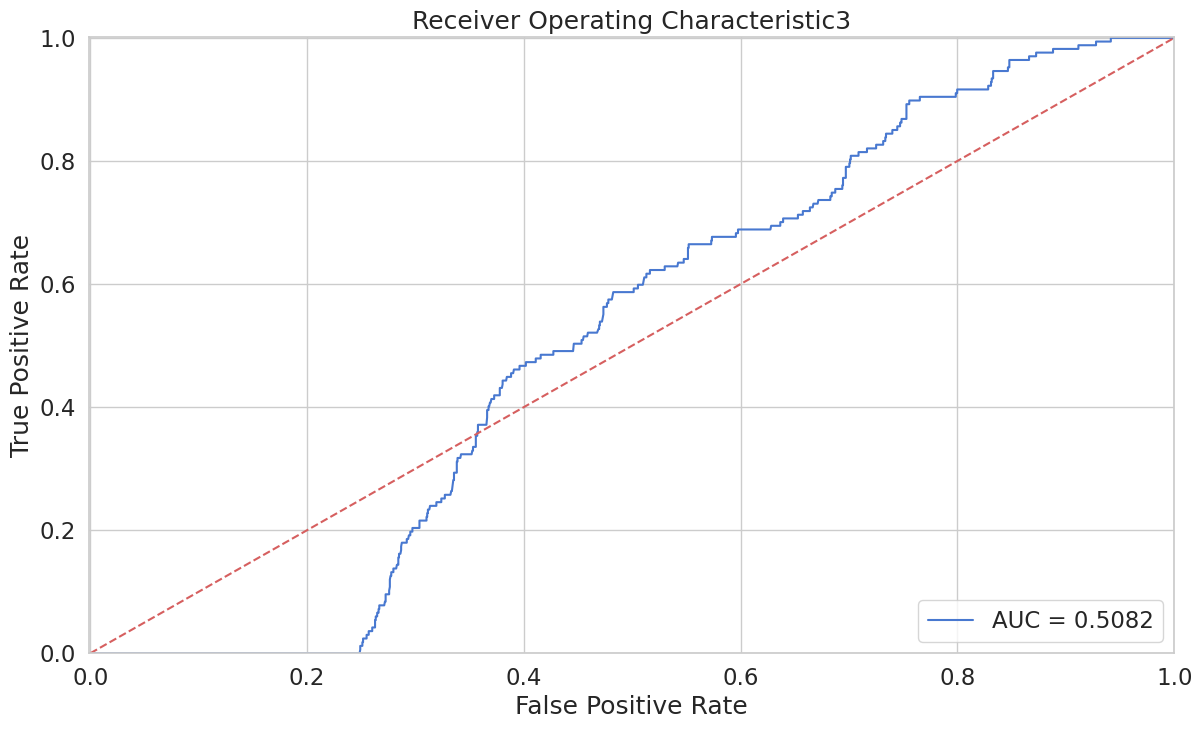

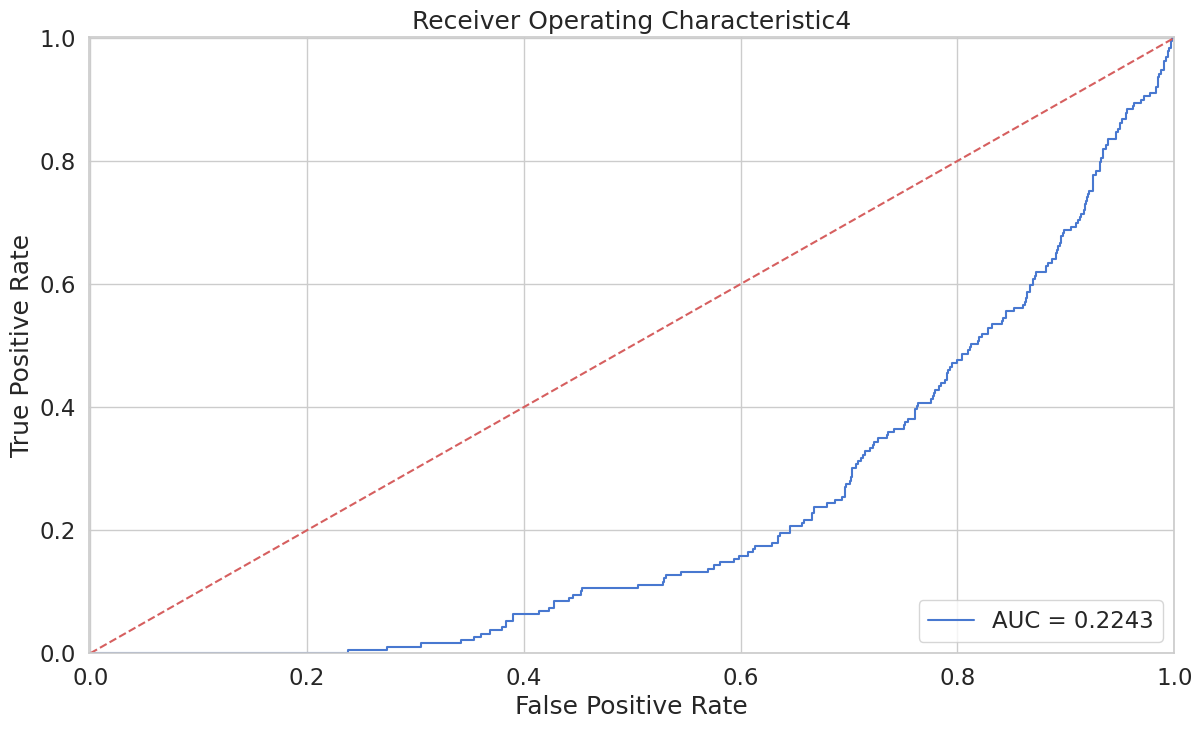

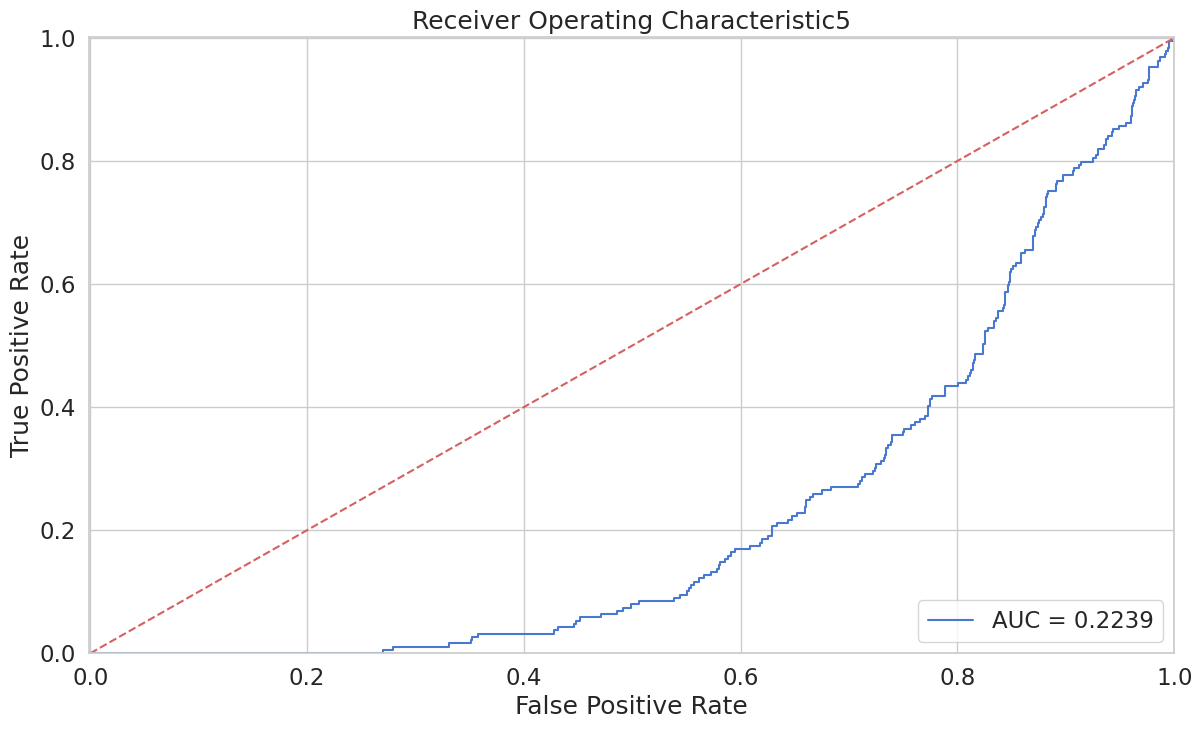

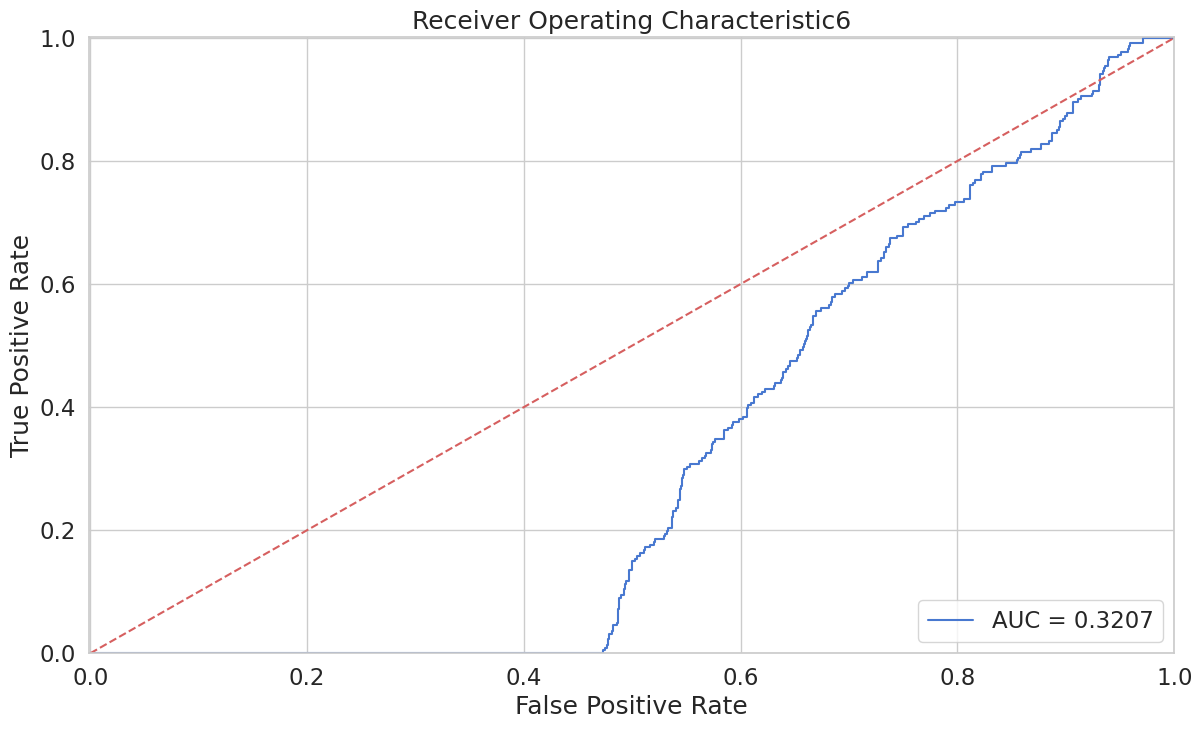

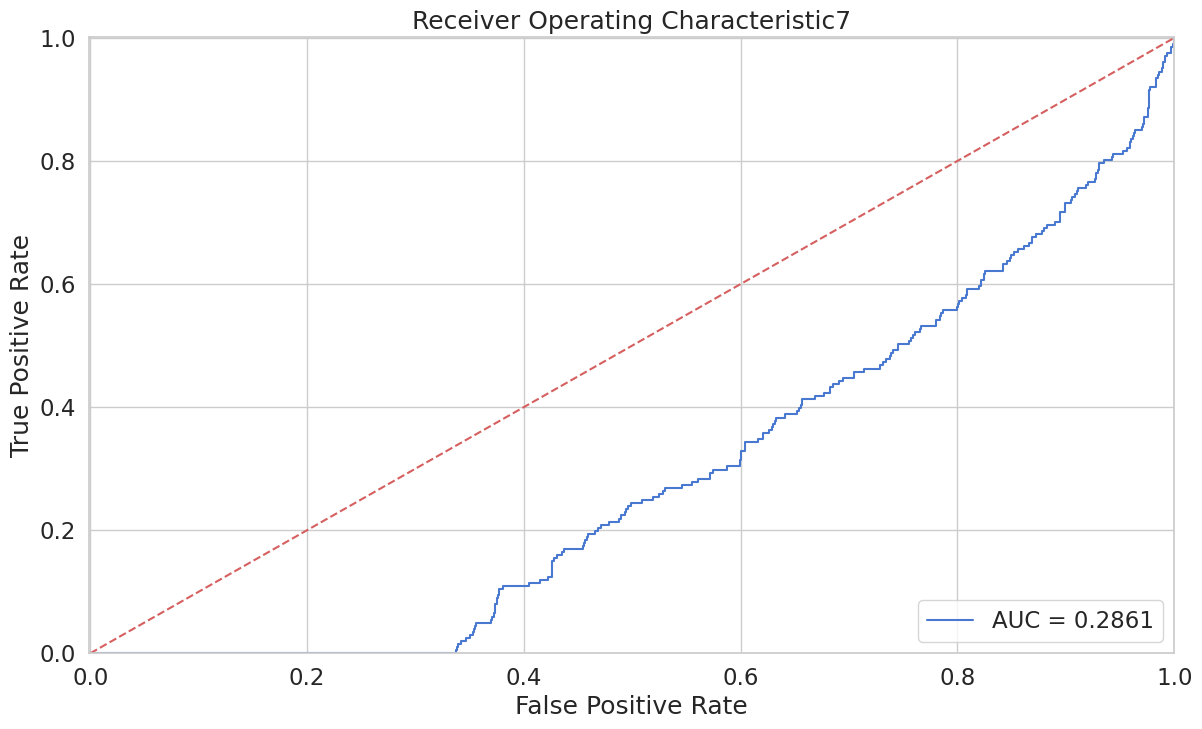

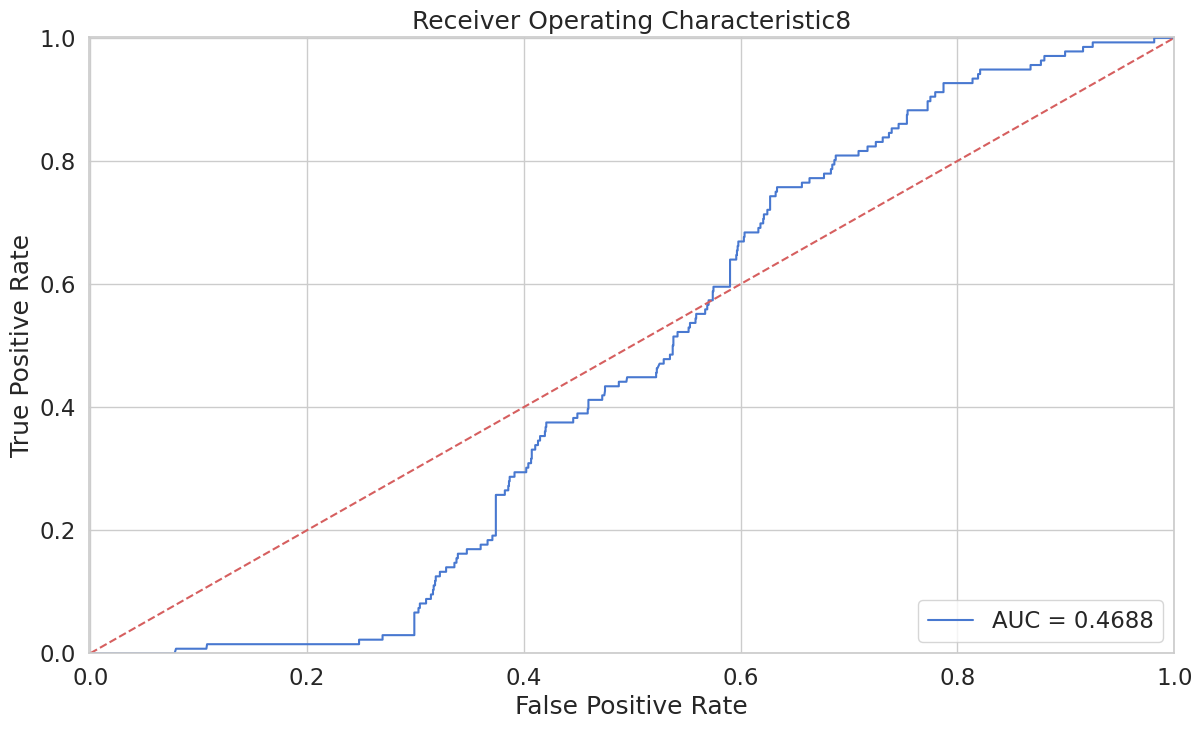

'\nпостроим графики\n\n'

In [ ]:
'''
ROC (для каждого класса по отдельности)
'''
for class_i in classes:

    reconstructionErrorDF_one_class = compute_class(reconstructionErrorDF.track_genre,class_i)
    fpr, tpr, thresholds = roc_curve(reconstructionErrorDF_one_class, reconstructionErrorDF.pred_loss)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic' + str(class_i))
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();

'''
построим графики

'''

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

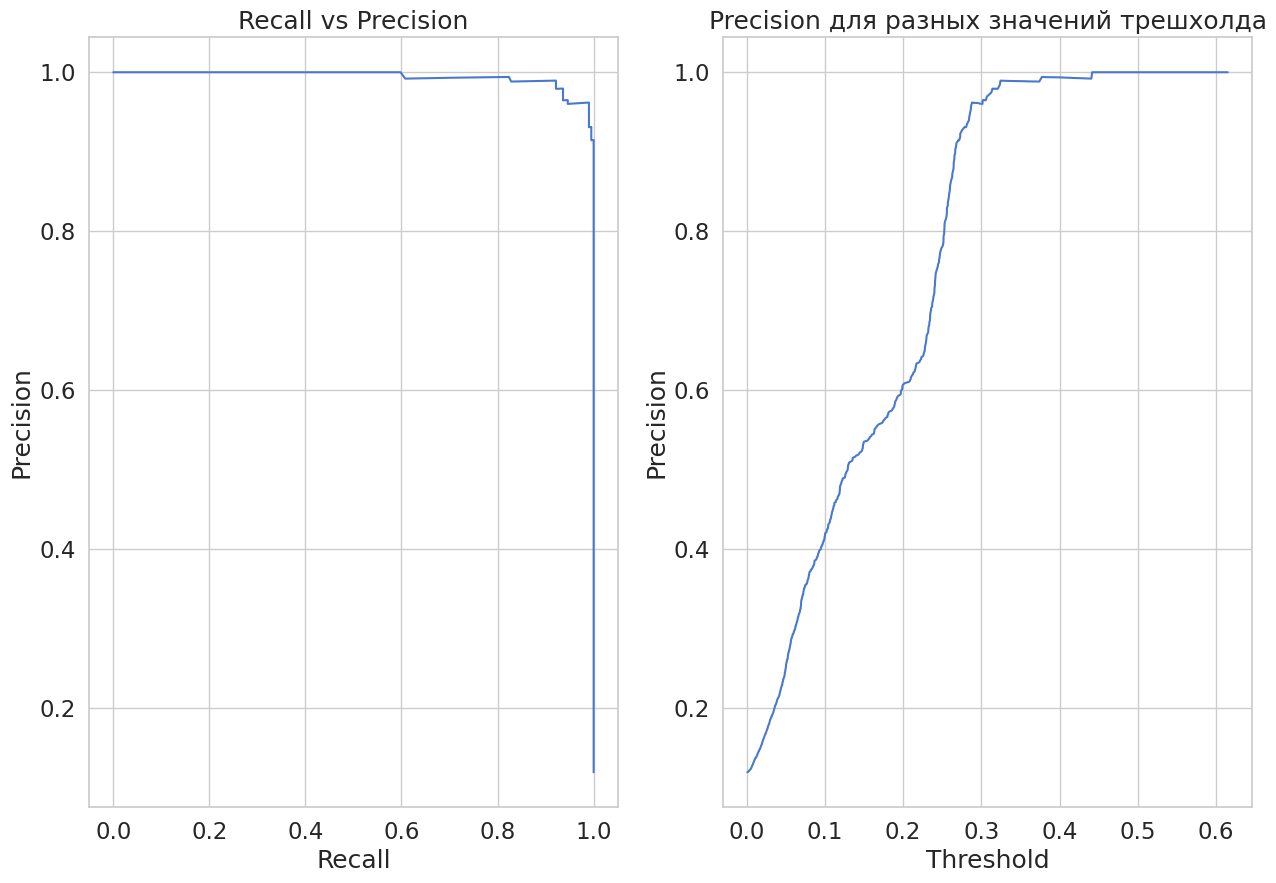

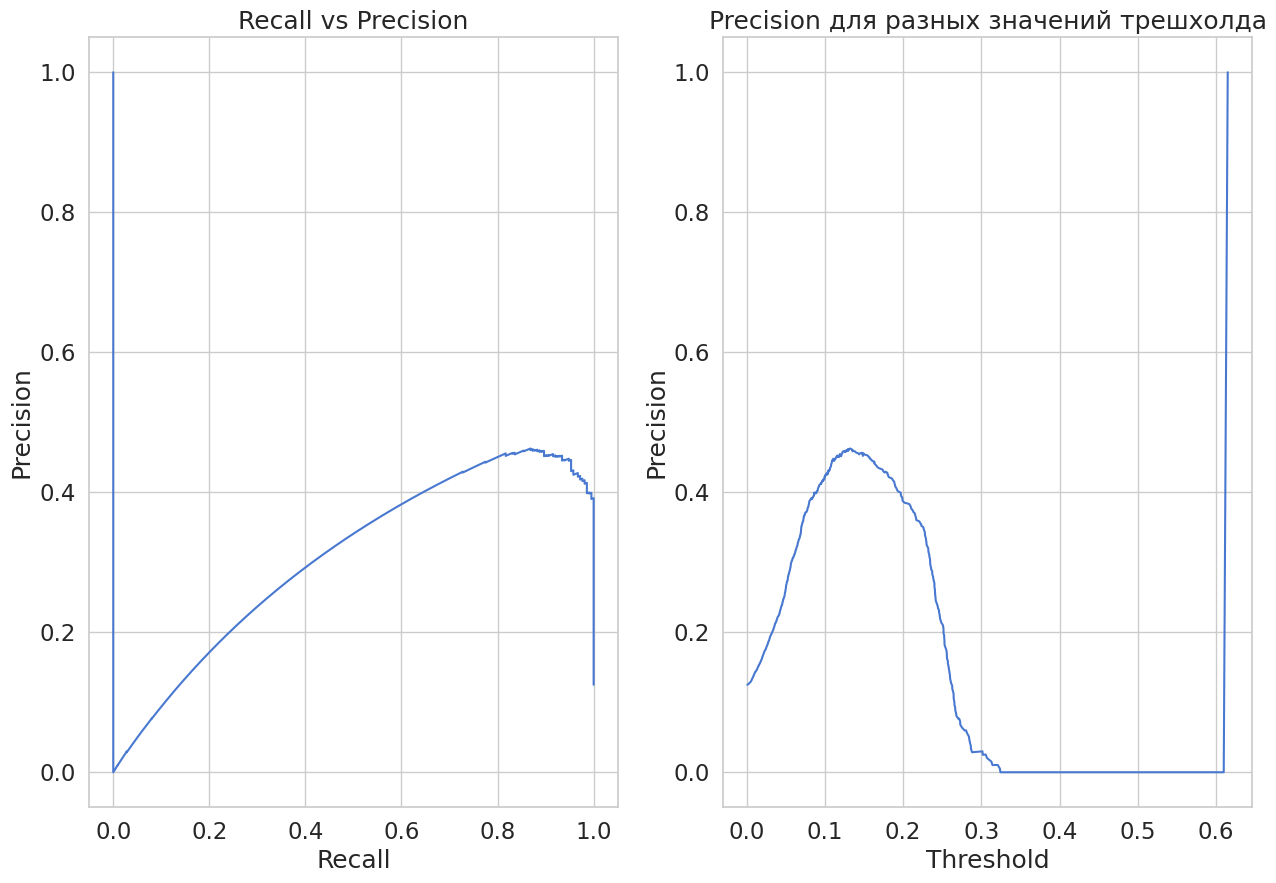

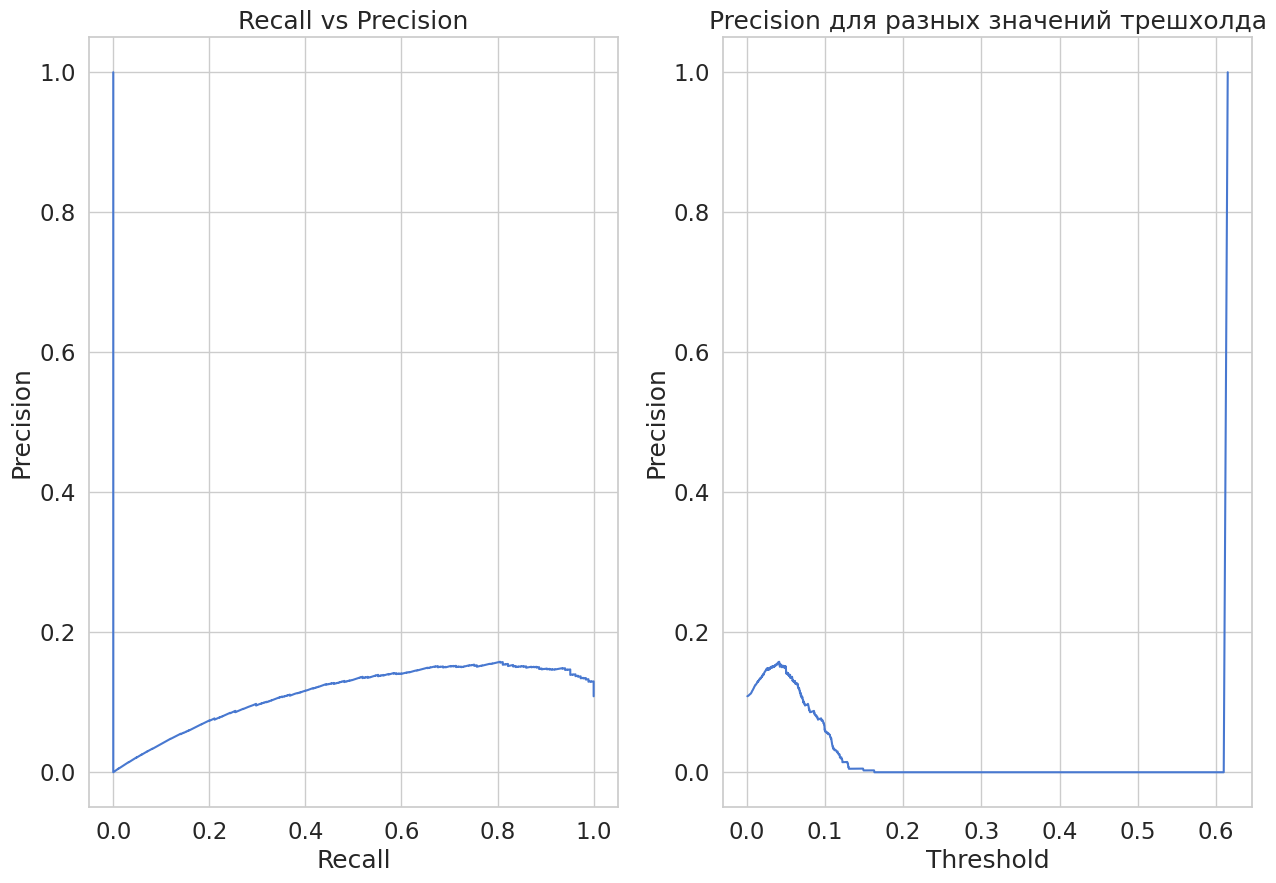

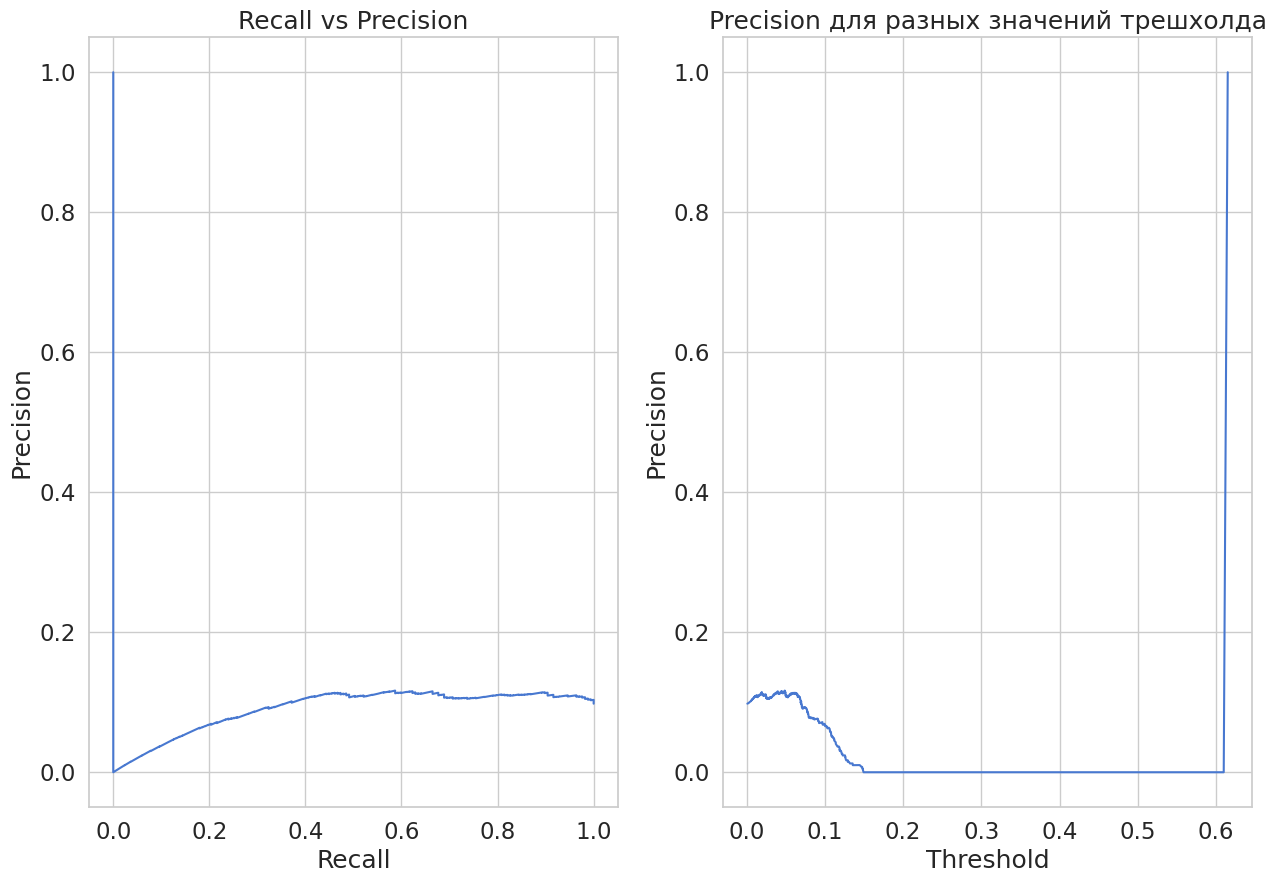

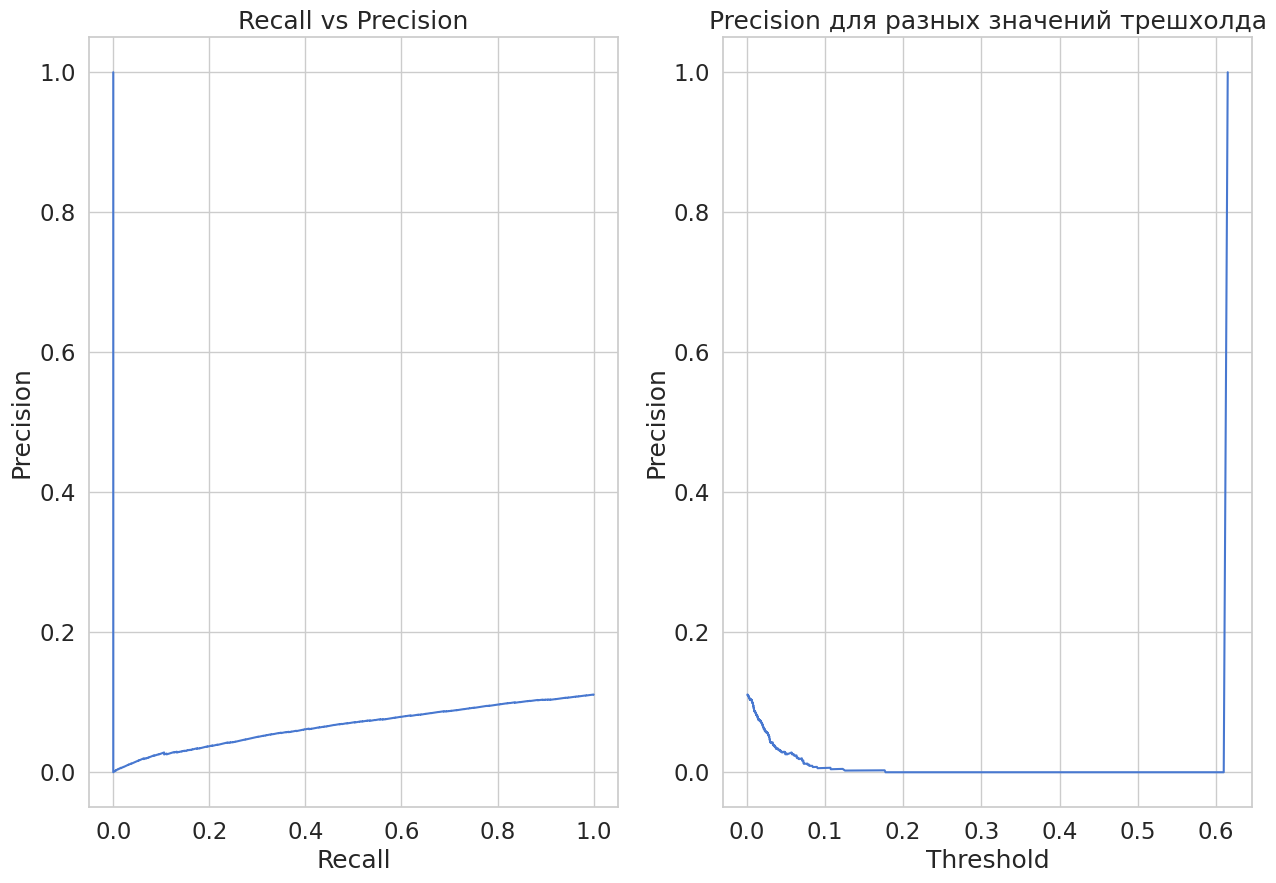

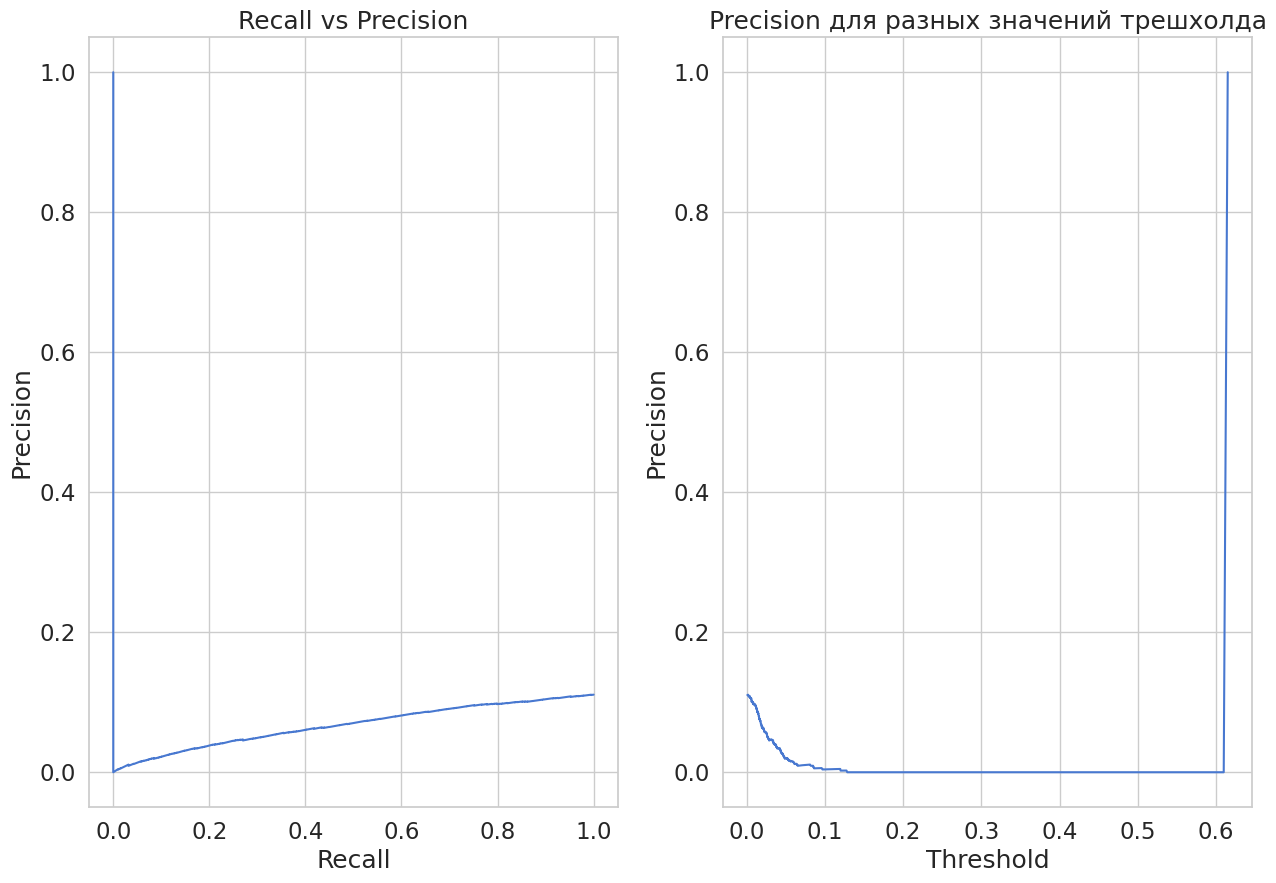

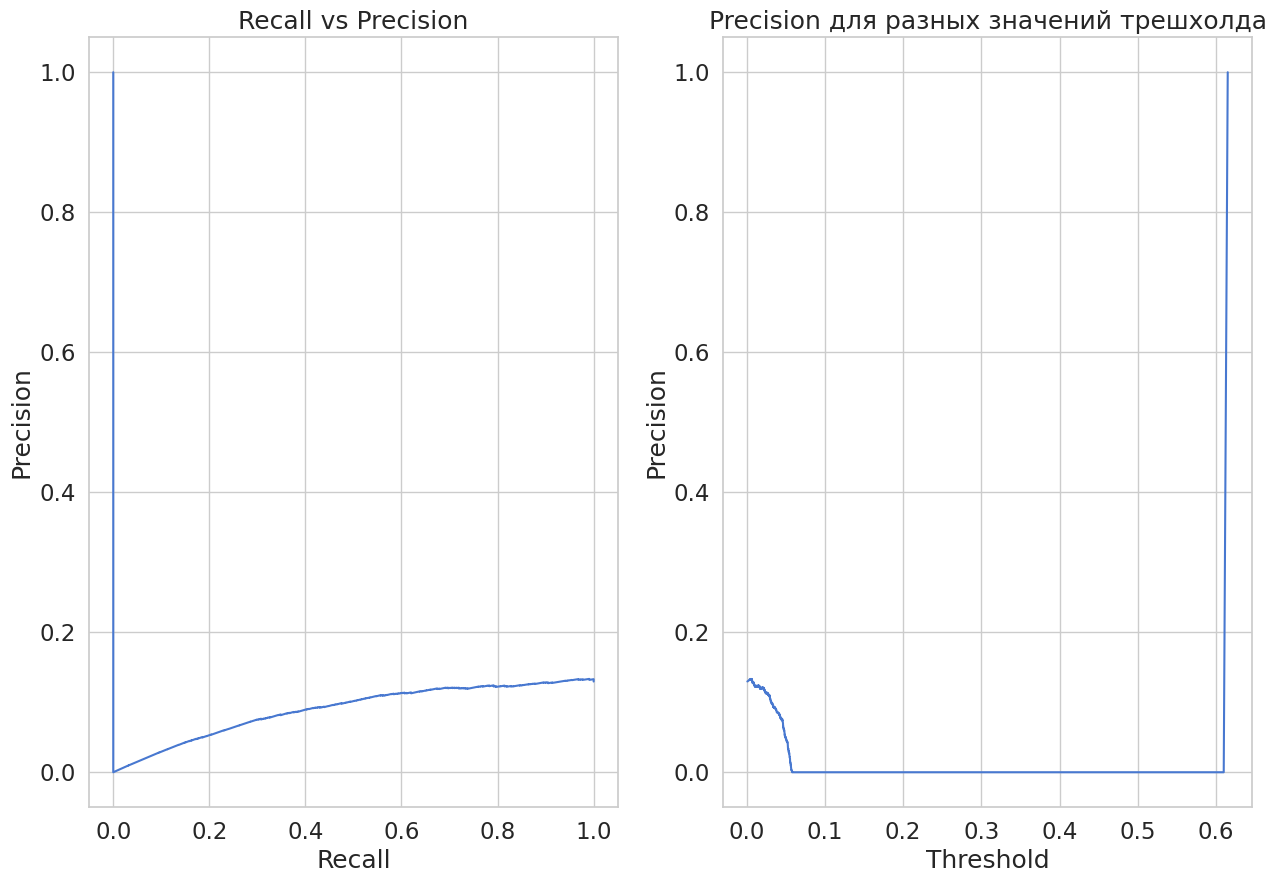

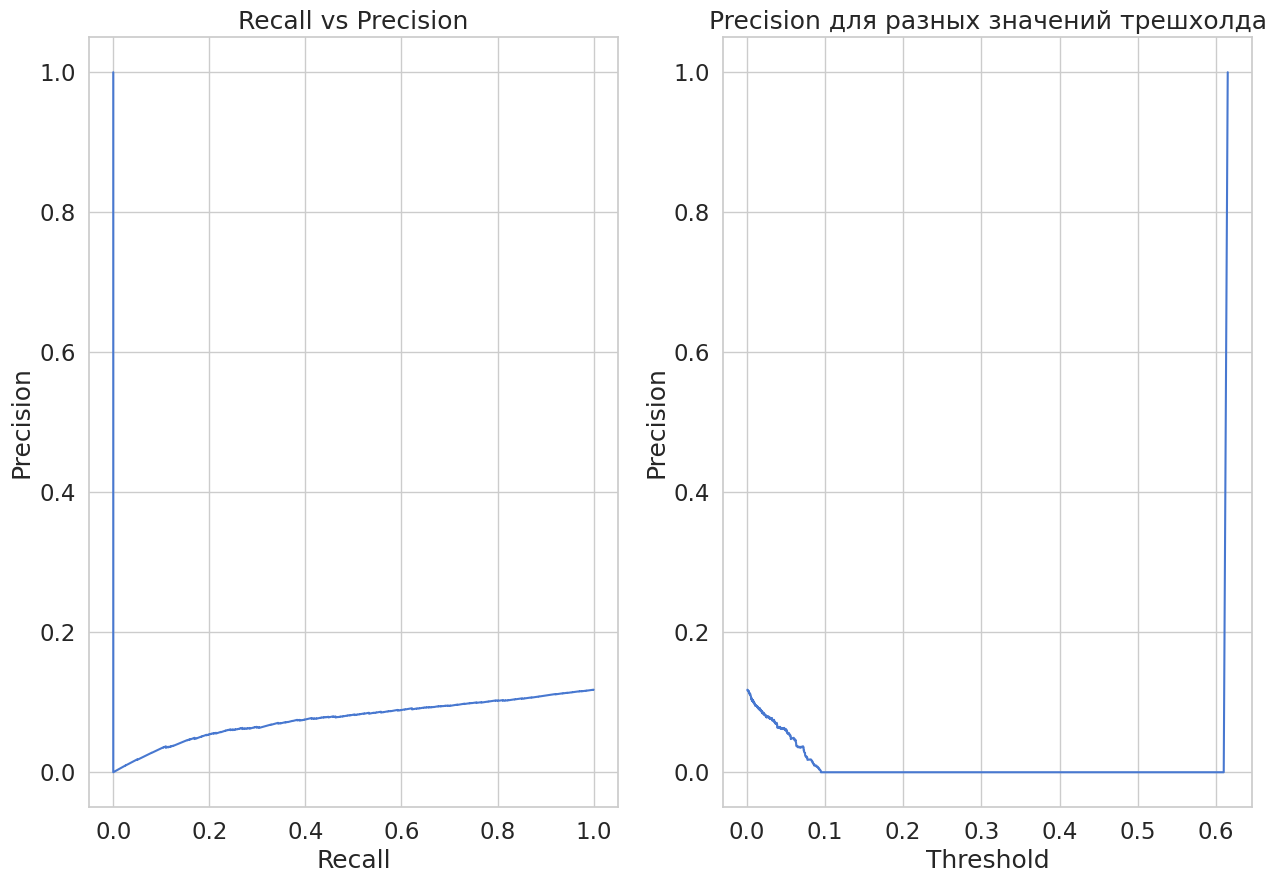

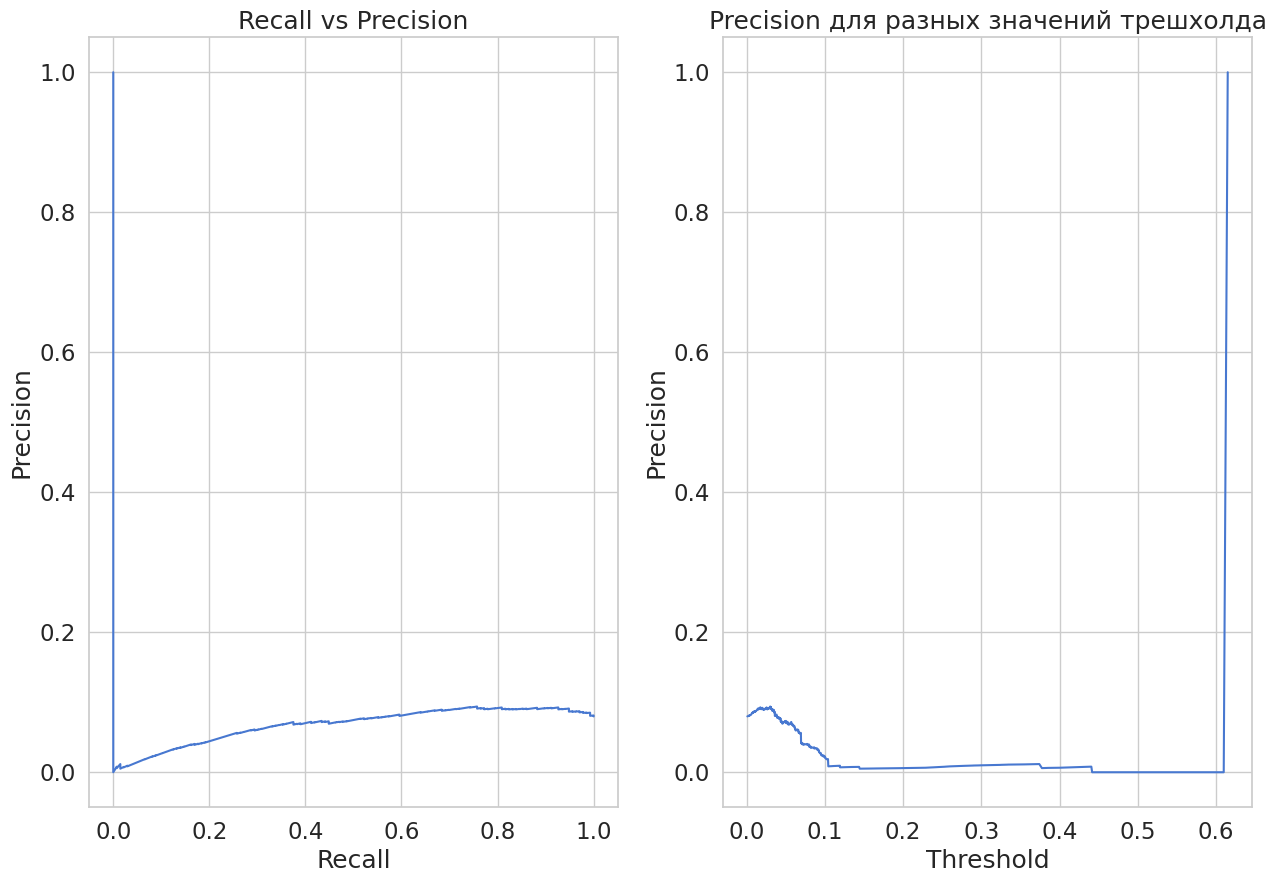

'\nпостроим графики\n\n'

In [ ]:
'''
Precision vs Recall (для каждого класса по отдельности)
'''
for class_i in classes:
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10),dpi=100)
    reconstructionErrorDF_one_class = compute_class(reconstructionErrorDF.track_genre,class_i)
    precision, recall, th = precision_recall_curve(reconstructionErrorDF_one_class, reconstructionErrorDF.pred_loss)
    ax[0].plot(recall, precision, 'b', label='Precision-Recall curve')
    ax[0].set(xlabel='Recall', ylabel="Precision", title="Recall vs Precision")
    ax[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
    ax[1].set(xlabel='Threshold', ylabel="Precision", title="Precision для разных значений трешхолда")

    plt.show()
'''
построим графики

'''

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, принадлежит ли трек к 8 жанру или к остальным, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как 8класс (поскольку наша модель должна иметь низкую ошибку при остальных жанрах). Давайте выберем это значение:

In [ ]:
threshold = 0.3

In [ ]:
groups.value_counts()


track_genre  pred_loss
0            0.926062     4
             0.687096     2
             0.923442     2
             0.405159     1
             0.441511     1
                         ..
8            0.234744     1
             0.242231     1
             0.264691     1
             0.677615     1
             0.687096     1
Name: count, Length: 1661, dtype: int64

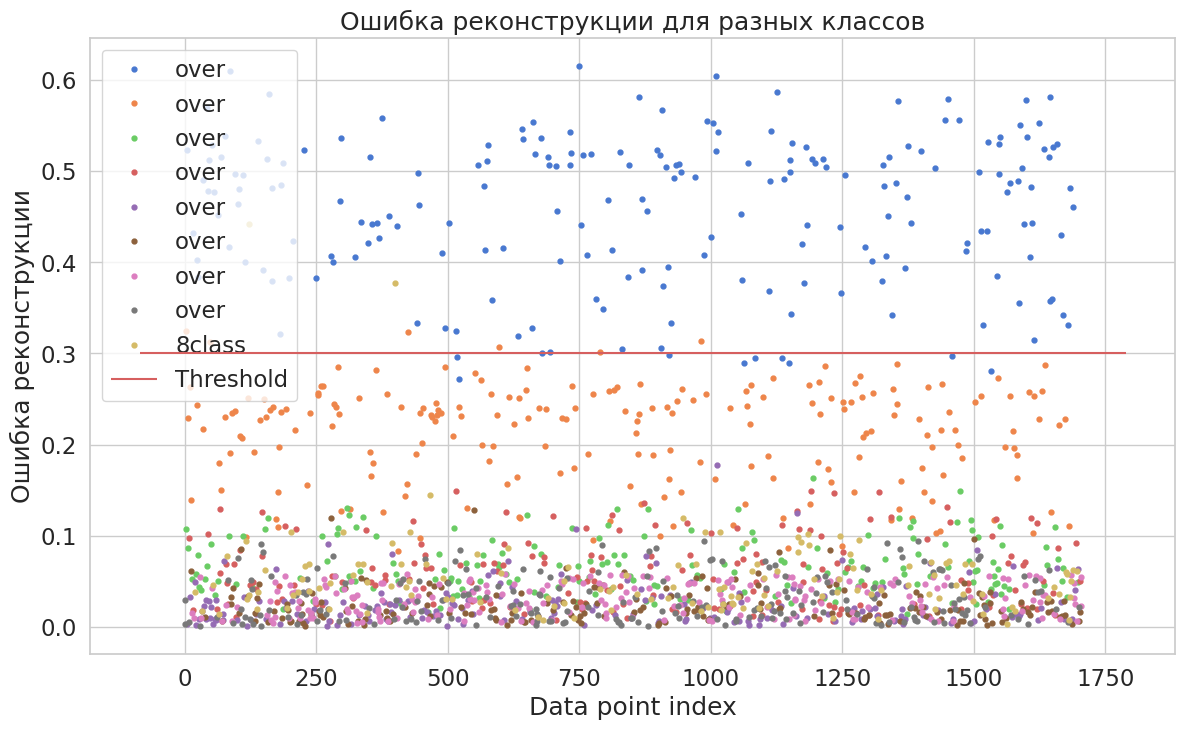

In [ ]:
groups = reconstructionErrorDF.groupby('track_genre')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "8class" if name == 8 else "over")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


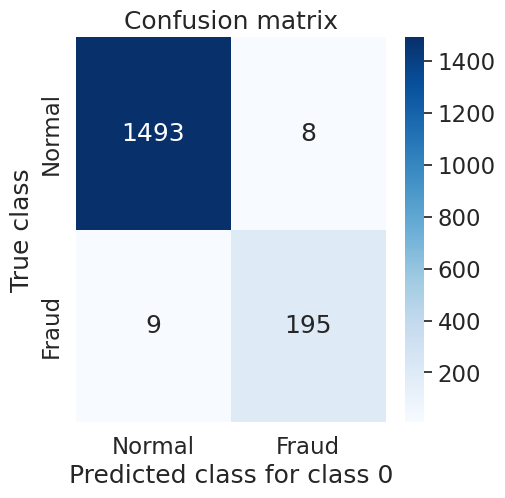

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


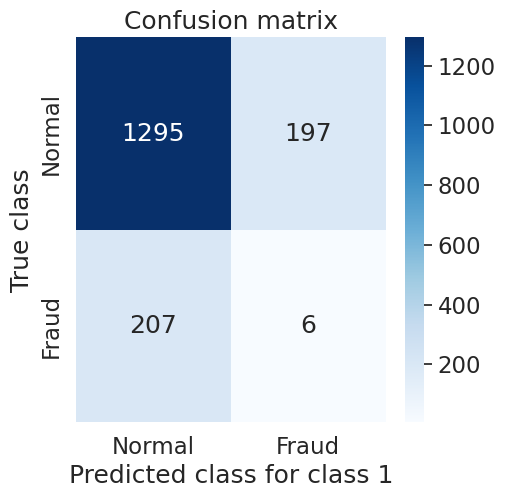

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


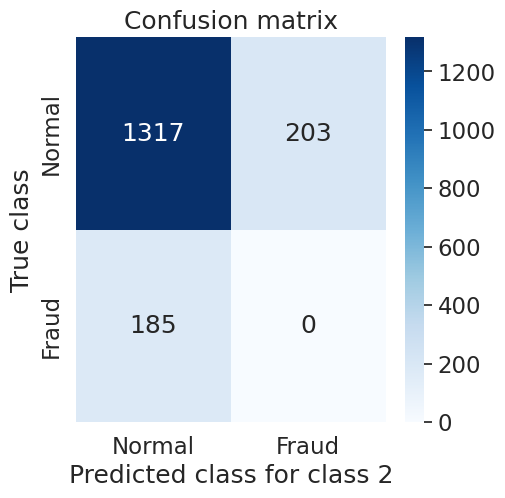

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


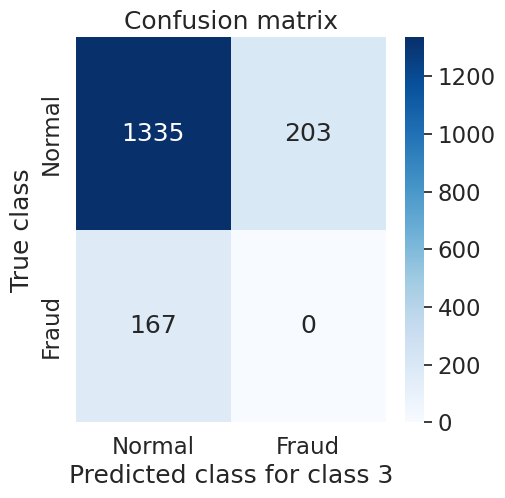

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


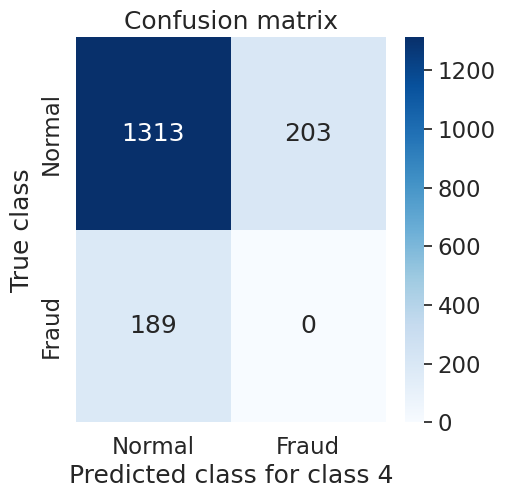

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


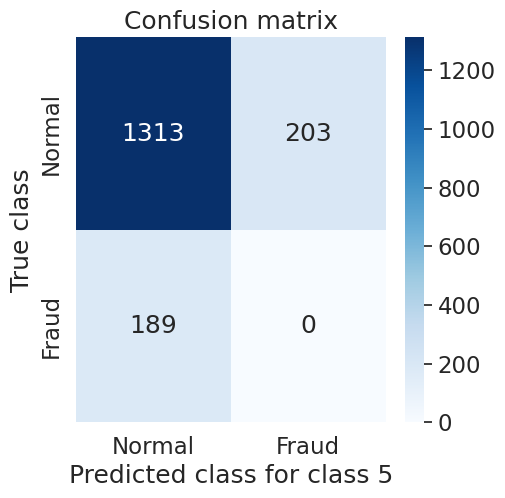

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


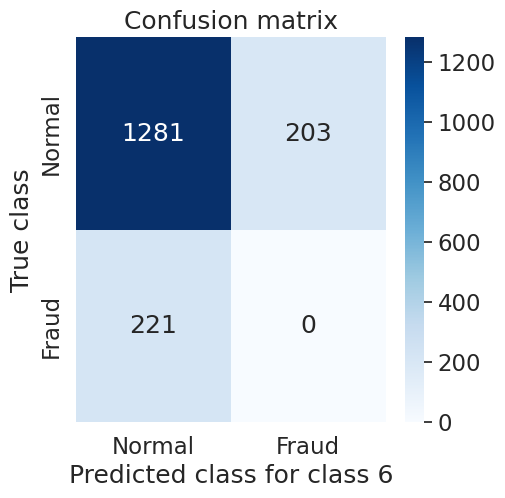

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


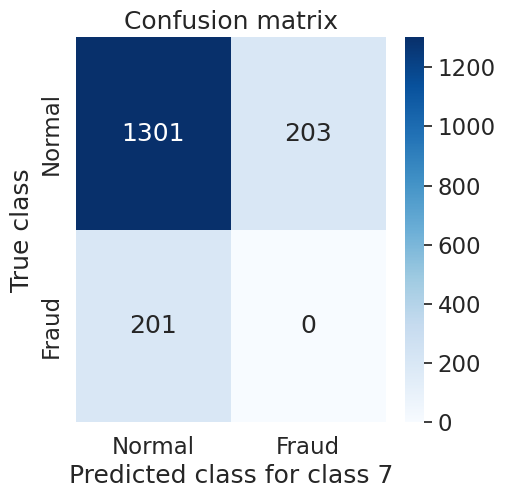

<ipython-input-75-ca48a9ca963c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'))


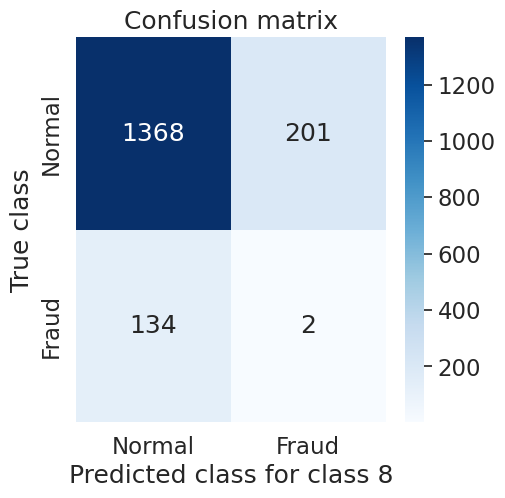

'\nпостроим график\n\n'

In [ ]:
'''
Confusion matrix (для каждого класса по отдельности)
'''


for class_i in classes:

    # y_one_class = compute_class(y_test,class_i)
    # predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
    # cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    # sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    # ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
    # ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    # ax[class_i].set_yticklabels(labels=lbs, rotation=0)

    reconstructionErrorDF_one_class = compute_class(reconstructionErrorDF.track_genre,class_i)
    y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
    conf_matrix = confusion_matrix(reconstructionErrorDF_one_class, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
                cmap=plt.cm.get_cmap('Blues'))
    # ax[class_i].set(xlabel="Predicted class", ylabel="True class", title=f"Confusion matrix for class {class_i} ")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class for class '+ str(class_i))
    plt.show()
'''
построим график

'''
# plt.show()

Наша модель, похоже, предназначена для бинарной классификации, а не многоклассовой.

## Выводы


ВЫВОДЫ
<!-- Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент. -->